## Le deuxième objectif du projet consiste à expliciter et à implémenter 2 approches de transfer learning : 
**A : l’utilisation des features d’un DL avant la couche dense comme représentation des images puis apprentissage d’un modèle de ML “classique”**
**B : fine-tuning d'un modèle existant à de nouvelles données**

# Transfer learning de type A 

In [1]:
#changement de répertoire
import os
os.chdir("C:/MLDL")

## Avec Resnet50

In [2]:
#TRANSFER LEARNING
#The authors did that : using feature extraction from ImageNet VGG16 - library : keras
#We do : using feature extraction from ImageNet RESNet50 - library : pytorch
import torch
import torch.nn as nn
import torchvision.models as models

conv_base = models.resnet50(pretrained=True)
layers = list(conv_base.children())[:-2] #on a un poids de 2048 
conv_base = nn.Sequential(*layers) 
conv_base.eval()

C:\Users\chrys\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\chrys\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [3]:
#Method 1: Fast feature extraction without data augmentation
#Run the conv_base on the dataset and save as Numpy array on disk
#Then build the dense layer on this
#This is faster to run, but we cannot augment the data

import torchvision.transforms as transforms
from torchvision import datasets

train_dir = "C:/MLDL/train_another"
validation_dir = "C:/MLDL/validation_another"
test_dir = "C:/MLDL/test"
#transform
data_transform = transforms.Compose([
    transforms.Resize(150),
    transforms.CenterCrop(150),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_dataset = datasets.ImageFolder(train_dir, transform=data_transform)
validation_dataset = datasets.ImageFolder(validation_dir, transform=data_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=data_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=20, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=20, shuffle=False)

In [4]:
#define extract_features
#generators yield data indefinitely
#have to break after we have seen every image once
#try parallized (cuda)

import torch.cuda


def extract_features(directory, sample_count, batch_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    features = torch.zeros(size=(sample_count,2048,5,5), dtype=torch.float32).to(device)#on impute les poids de Resnet
    labels = torch.zeros(size=(sample_count,), dtype=torch.long).to(device)


    data_transform = transforms.Compose([
        transforms.Resize((150,150)), #dimension de la cible
        transforms.ToTensor()
    ])

    image_dataset = datasets.ImageFolder(root=directory, transform=data_transform)
    data_loader = torch.utils.data.DataLoader(image_dataset, batch_size=batch_size, shuffle=False)

    i = 0
    for inputs_batch, labels_batch in data_loader:
        inputs_batch, labels_batch = inputs_batch.to(device), labels_batch.to(device)
        with torch.no_grad():
            features_batch = conv_base(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break

    return features, labels

In [10]:
train_features, train_labels = extract_features(train_dir, 10000, 20)
validation_features, validation_labels = extract_features(validation_dir, 2000, 20) #batchs(20) à remettre en pyTorch
test_features, test_labels = extract_features(test_dir, 2000, 20)

In [6]:
#Etape de flatten
train_features = train_features.reshape(10000, 2048*5*5)
validation_features = validation_features.reshape(2000, 2048*5*5)
test_features = test_features.reshape(2000, 2048*5*5)

In [31]:
#etape de tentatives divers et variées pour réussir à connecter ensuite la couche connectéee complètement
import numpy as np
train_features = np.reshape(train_features, (10000, 2048*5*5))
validation_features = np.reshape(validation_features, (2000, 2048*5*5))
test_features = np.reshape(test_features, (2000, 2048*5*5))

In [35]:
#define the densely connected layer
#import Optimizers
import torch.optim as optim


class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()
        self.fc1 = nn.Linear(2048*5*5, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256,1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'#pour activer la parallélisation
model = DenseNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=2e-5)

train_labels = train_labels.reshape(-1, 1).float()


for epoch in range(30):
    # Forward pass
    outputs = model(train_features)
    loss = criterion(outputs, train_labels)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}' 
               .format(epoch+1, 30, loss.item()))

Epoch [10/30], Loss: 0.3796
Epoch [20/30], Loss: 0.3474
Epoch [30/30], Loss: 0.2918


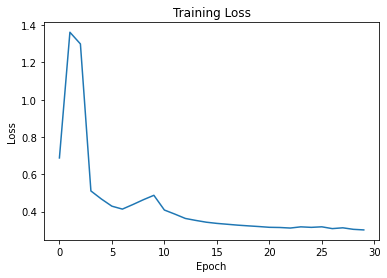

In [47]:
import seaborn as sns
sns.lineplot(x=range(30), y=loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [36]:
#save the model with pretrained features in Numpy array (no data augmentation)
torch.save(model.state_dict(), 'tomnod_transfer_RESNET.pt')

# Transfer learning de type B

In [ ]:
#feature extraction with data augmentation and dropout
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class ConvNet(nn.Module):
    def __init__(self, conv_base):
        super(ConvNet, self).__init__()
        self.conv_base = conv_base
        self.fc1 = nn.Linear(150 * 150 * 3, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.conv_base(x)
        x = x.view(-1, 150 * 150 * 3)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return 

In [ ]:
conv_base = ... # The pre-trained convolutional base
model = ConvNet(conv_base)

for param in model.conv_base.parameters():
    param.requires_grad = False

train_datagen = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(40),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(1, 1), shear=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_datagen = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_dataset = datasets.ImageFolder(root='C:/MLDL/train_another', transform=train_datagen)
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True)

test_dataset = datasets.ImageFolder(root='C:/MLDL/validation_another', transform=test_datagen)
test_dataloader = DataLoader(test_dataset, batch_size=20, shuffle=True)

criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=2e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = criterion.to(device)

history = []
for epoch in range(30):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss +=

In [ ]:
#save the model with transfer learning and data augmentation
torch.save(model.state_dict(), 'tomnod_transfer_dataAugment.pt')

In [ ]:
#plot loss and accuracy for detection overfitting

import matplotlib.pyplot as plt
#Get the training and validation accuracy and loss from the training history
train_acc = history['train_accuracy'] 
val_acc = history['val_accuracy'] 
train_loss = history['train_loss'] 
val_loss = history['val_loss']
#Get the number of epochs
epochs = range(1, len(train_acc) + 1)
#Plot the training and validation accuracy
plt.plot(epochs, train_acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'r', label='Validation acc') 
plt.title('Training and validation accuracy with pretrained features and data augmentation') 
plt.legend()
plt.figure()
#Plot the training and validation loss
plt.plot(epochs, train_loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'r', label='Validation loss') 
plt.title('Training and validation accuracy with pretrained features and data augmentation') 
plt.legend()
plt.show()

# Transfer learning de Type A - autres modèles de Machine learning

In [ ]:
# a logistic regression using Numpy array features (after passing through convultional based)
#nous retrouvons les mêmes résultats que les auteurs

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

# XGBoost
xgb_pipeline = Pipeline([("xgb", XGBClassifier(n_jobs=-1))])
xgb_pipeline.fit(train_features, train_labels)
xgb_score1 = xgb_pipeline.score(validation_features, validation_labels)
print("Validation accuracy (XGBoost) = ", xgb_score1)
xgb_score2 = xgb_pipeline.score(test_features, test_labels)
print("Test accuracy (XGBoost) = ", xgb_score2)

# Random Forest
rf_pipeline = Pipeline([("rf", RandomForestClassifier(n_jobs=-1))])
rf_pipeline.fit(train_features, train_labels)
rf_score1 = rf_pipeline.score(validation_features, validation_labels)
print("Validation accuracy (Random Forest) = ", rf_score1)
rf_score2 = rf_pipeline.score(test_features, test_labels)
print("Test accuracy (Random Forest) = ", rf_score2)

# LightGBM
lgbm_pipeline = Pipeline([("lgbm", lgb.LGBMClassifier())])
lgbm_pipeline.fit(train_features, train_labels)
lgbm_score1 = lgbm_pipeline.score(validation_features, validation_labels)
print("Validation accuracy (LightGBM) = ", lgbm_score1)
lgbm_score2 = lgbm_pipeline.score(test_features, test_labels)
print("Test accuracy (LightGBM) = ", lgbm_score2)

In [ ]:
model = load_model('tomnod_2_100epochs.h5')

In [ ]:
from sklearn.metrics import roc_curve
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
                    "C:/MLDL/test_another", #change this for balanced/unbalanced test set 
                    target_size = (150,150),
                    batch_size = 20,
                    class_mode = 'binary')
y_pred = []
y_label = []
for i in range(450):
    x,y = test_generator.next()
    temp_y = model.predict(x)
    y.tolist()
    temp_y.tolist()
    y_pred.extend(temp_y)
    #print(temp_y)
    #print(y)
    #print('')
    y_label.extend(y)

In [ ]:
len(y_pred)

In [ ]:
len(y_label)

In [ ]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_label, y_pred,pos_label=1)

In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [ ]:
print(auc_keras)
#les auteurs ont trouvé 0.9963734999999999

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='AUC area = {:.3f}'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve of the best model with unbalanced test set')
plt.legend(loc='best')
plt.show()

In [ ]:
#see which image is misclassified
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
                    "C:/MLDL/test", #change this for balanced/unbalanced test set 
                    target_size = (150,150),
                    batch_size = 20,
                    class_mode = 'binary')
y_pred = []
y_label = []
for i in range(50):
    x,y = test_generator.next()
    y = y.ravel()
    temp_y = model.predict(x)
    temp_y = np.round(temp_y.ravel())
    misclassification = np.absolute(y-temp_y)

    #show the misclassification
    misclass_index = np.where(misclassification > 0.5)
    for j in range(len(misclass_index[0])):
        plt.figure()
        #print(misclass_index[0][j])
        plt.title('label is {}, prediction is {}'.format(y[misclass_index[0][j]],temp_y[misclass_index[0][j]]))
        plt.imshow(img_to_array(x[misclass_index[0][j]]))
    misclass_index = None

In [ ]:
#to see how the generator encodes the images into binary or multiclass:
test_generator.class_indices

In [ ]:
test_generator.classes